<a href="https://colab.research.google.com/github/zosiak00/uczenie_maszynowe_ZK/blob/case3/case3_ZK.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



Stwórz model generujący sygnały kupna i sprzedaży na rynku

Decyzje ma generować jeden z algorytmów uczenia maszynowego, po optymalizacji hiperparametrów

Zrób backtest wybranego modelu, użyj biblioteki przystosowanej do backtestów

Pamiętaj o wnioskach i wizualizacji wyników


In [1]:
pip install backtesting

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 1.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for backtesting: filename=Backtesting-0.3.3-py3-none-any.whl size=173916 sha256=07e20fbb37139467673f9050c69ee8ecb6f26b719906b17de320777aef499964
  Stored in directory: /root/.cache/pip/wheels/e2/30/7f/19cbe31987c6ebdb47f1f510343249066711609e3da2d57176
Successfully built backtesting


In [2]:
pip install backtrader

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 419.5/419.5 kB 5.0 MB/s eta 0:00:00


In [3]:
pip install yfinance

In [26]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import datetime
from typing import Callable
import pandas_datareader.data as web
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import backtrader as bt
from backtesting import Strategy, Backtest
from sklearn.metrics import balanced_accuracy_score

In [4]:
# 1 spos. odczytania danych
# def read_data(name, start, end):
#   data = yf.download(name, start=start, end=end)
#   return data

# data = read_data('AAPL', start, end)
# data.head()

# Dates
#start, end = '2024-01-01', '2024-05-06'

# Window length for moving average
#length = 14

In [10]:
# data['Return'] = data['Adj Close'].pct_change()
# data['Direction'] = np.where(data['Return'] > 0, 1, 0)
# X = data[['Open', 'High', 'Low', 'Close', 'Volume']].values
# y = data['Direction'].values

In [18]:
# 2 spos. odczytania danych
train_data = yf.download('AAPL', start='2021-01-01', end='2023-12-31')
test_data = yf.download('AAPL', start='2024-01-01', end='2024-05-06')
train_data = train_data.dropna()
test_data = test_data.dropna()

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [19]:
# Przygotuj dane dla modelu
train_data['Return'] = train_data['Adj Close'].pct_change()
train_data['Direction'] = np.where(train_data['Return'] > 0, 1, 0)
X_train = train_data[['Open', 'High', 'Low', 'Close', 'Volume']].values
y_train = train_data['Direction'].values

test_data['Return'] = test_data['Adj Close'].pct_change()
test_data['Direction'] = np.where(test_data['Return'] > 0, 1, 0)
X_test = test_data[['Open', 'High', 'Low', 'Close', 'Volume']].values
y_test = test_data['Direction'].values


In [7]:
# Zbuduj model lasu losowego
rf = RandomForestClassifier()

# Zdefiniuj siatkę hiperparametrów do optymalizacji
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10]
}

# Optymalizacja hiperparametrów
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Najlepsze parametry
best_params = grid_search.best_params_
print(f'Najlepsze parametry: {best_params}')


Najlepsze parametry: {'max_depth': 15, 'min_samples_split': 2, 'n_estimators': 300}


In [20]:
# Użyjemy najlepszego modelu
best_rf = RandomForestClassifier(**best_params)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, n_estimators=300)

In [17]:
y_pred_train = best_rf.predict(X_train)
y_pred_test = best_rf.predict(X_test)

# Ocena modelu
train_accuracy = balanced_accuracy_score(y_train, y_pred_train)
test_accuracy = balanced_accuracy_score(y_test, y_pred_test)

print(train_accuracy)
print(test_accuracy)

1.0
0.6494444444444445


In [27]:
# backtesting

class MLStrategy(bt.Strategy):
    params = (
        ('model', None),
    )

    def __init__(self):
        self.dataclose = self.datas[0].close
        self.model = self.params.model
        self.data_df = pd.DataFrame(columns=['Open', 'High', 'Low', 'Close', 'Volume'])

    def next(self):
        # Dodaj nowe dane do DataFrame
        new_data = pd.DataFrame({
            'Open': [self.datas[0].open[0]],
            'High': [self.datas[0].high[0]],
            'Low': [self.datas[0].low[0]],
            'Close': [self.datas[0].close[0]],
            'Volume': [self.datas[0].volume[0]]
        })
        self.data_df = pd.concat([self.data_df, new_data], ignore_index=True)

        # Musi być przynajmniej 100 wierszy danych do predykcji
        if len(self.data_df) > 100:
            X_new = self.data_df[['Open', 'High', 'Low', 'Close', 'Volume']].values[-1].reshape(1, -1)
            prediction = self.model.predict(X_new)

            if prediction == 1 and not self.position:
                self.buy(size=100)
            elif prediction == 0 and self.position:
                self.sell(size=100)



In [ ]:
# Przeprowadzenie backtestu
cerebro = bt.Cerebro()
data_feed = bt.feeds.PandasData(dataname=test_data)
cerebro.adddata(data_feed)
cerebro.addstrategy(MLStrategy)
cerebro.run()

In [ ]:
bt = Backtest(test_data, MLStrategy, cash=10000, commission=.002)
stats = bt.run()
bt.plot()

# Wyświetlanie statystyk
print(stats)

<IPython.core.display.Javascript object>

[[<Figure size 640x480 with 4 Axes>]]

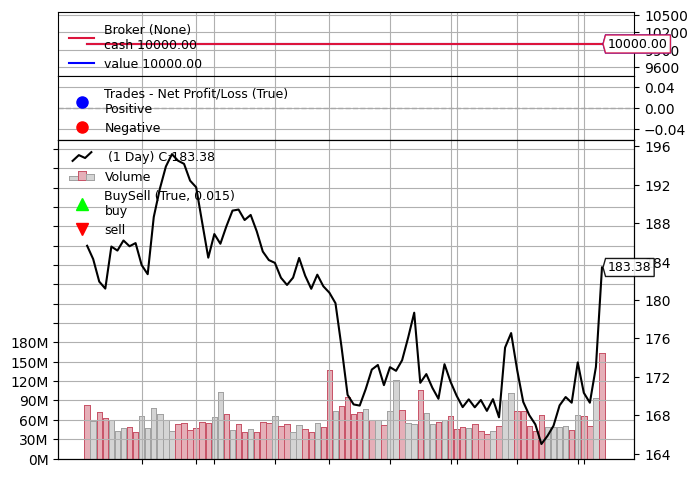

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
cerebro.plot()

Opis przyjętej strategii:

1. pobieramy historyczne dane dotyczące cen akcji 'AAPL' z Yahoo Finance. Dane te obejmują ceny otwarcia, maksymalne, minimalne, zamknięcia oraz wolumen obrotu.

2. obliczamy dzienne zwroty z inwestycji na podstawie cen zamknięcia (Adjusted Close) i dodajemy kolumnę Direction, która wskazuje, czy cena wzrosła (1) czy spadła (0).

3. Budowa modelu:
dane są dzielone na zestawy treningowy i testowy. Model RandomForestClassifier jest trenowany na tych danych, a hiperparametry są optymalizowane za pomocą GridSearchCV.

4. Strategia w Backtrader: co krok czasowy (np. codziennie), nowe dane rynkowe są dodawane do DataFrame'u, a następnie model przewiduje kierunek ruchu cen na podstawie najnowszych danych.

5. Strategia jest testowana za pomocą Backtrader na historycznych danych, a wyniki są wizualizowane.

<Figure size 1000x500 with 0 Axes>

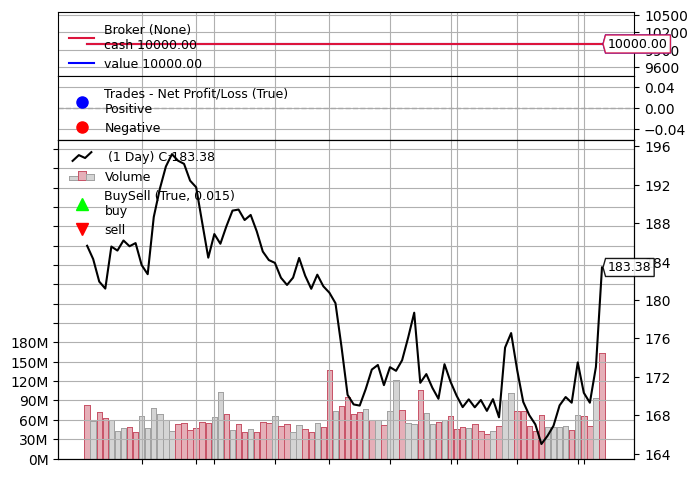

In [22]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# import backtrader as bt

# # przeprowadzenie backtestu dla modelu ze zoptymalizowanymi hiperparametrami

# # Tworzenie instancji cerebro
# cerebro2 = bt.Cerebro()
# cerebro2.adddata(bt.feeds.PandasData(dataname=data))
# cerebro2.addstrategy(MLStrategy, model=best_rf)
# results = cerebro2.run()

# plt.figure(figsize=(10, 5))
# cerebro2.plot(iplot=False)
# plt.show()
